Аналитика и визуализация.  
Вам предоставлена выгрузка платежей (файл synthetical_payments.csv) за последние несколько лет. Расскажите на основе этих данных, как чувствует себя бизнес, насколько хорошо удаётся удерживать пользователей, нет ли каких-то проблем в пользовательских сегментах.    
Данные к заданию, в приложении к письму.    
Результат выполнения задания - наглядное представление происходящего с бизнесом. Форма может быть любой, от текста с картинками до воркбука в табло онлайн. Также приложите, пожалуйста, код, который написали для обработки данных и получения выводов.    

Контекст - платежи за подписочный сервис (мы заинтересованы, чтобы юзеры платили как можно дольше), у сервиса разные уровни (PRO->GURU->BUSINESS), юзеры могут со временем менять уровень подписки. Есть возможность платить каждый месяц, можно заплатить сразу за год и получить небольшую скидку.   

В данных 
price - цена продукта в месяц,   
amount - реально уплаченная сумма за подписку длительностью period.   
transactionTime - EPOCH time, в секундах.     

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (18,10)

In [2]:
df = pd.read_csv('synthetical_payments.csv')

In [3]:
df.head()

,userId,billingCountry,transactionTime,product,price,amount,period
0,41851,United States,1420334701,PRO,99.99,1007.90,12
1,13575,India,1420383152,PRO,99.99,99.99,1
2,73971,India,1420461487,PRO,99.99,99.99,1
3,80119,United States,1421010897,GURU,199.99,2015.90,12
4,90456,United States,1421020614,GURU,199.99,2015.90,12


In [4]:
df.shape

(38498, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38498 entries, 0 to 38497
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userId           38498 non-null  int64  
 1   billingCountry   38498 non-null  object 
 2   transactionTime  38498 non-null  int64  
 3   product          38498 non-null  object 
 4   price            38498 non-null  float64
 5   amount           38498 non-null  float64
 6   period           38498 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


In [6]:
df.isna().sum()

userId             0
billingCountry     0
transactionTime    0
product            0
price              0
amount             0
period             0
dtype: int64

In [7]:
df.describe()

,userId,transactionTime,price,amount,period
count,3.849800e+04,3.849800e+04,38498.000000,38498.000000,38498.000000
mean,5.849296e+04,1.487614e+09,171.435270,411.884691,2.788379
std,8.890725e+05,2.001986e+07,78.482071,681.548175,4.058854
min,2.000000e+00,1.420335e+09,99.990000,49.990000,1.000000
25%,2.575550e+04,1.475015e+09,99.990000,99.990000,1.000000
50%,5.046400e+04,1.491777e+09,199.990000,199.990000,1.000000
75%,7.642025e+04,1.503919e+09,199.990000,199.990000,1.000000
max,1.233211e+08,1.514768e+09,399.990000,30000.000000,12.000000


In [8]:
df['billingCountry'].value_counts(normalize=True)*100

United Kingdom    25.063640
United States     24.507767
France            20.782898
India             18.634734
Canada            11.010962
Name: billingCountry, dtype: float64

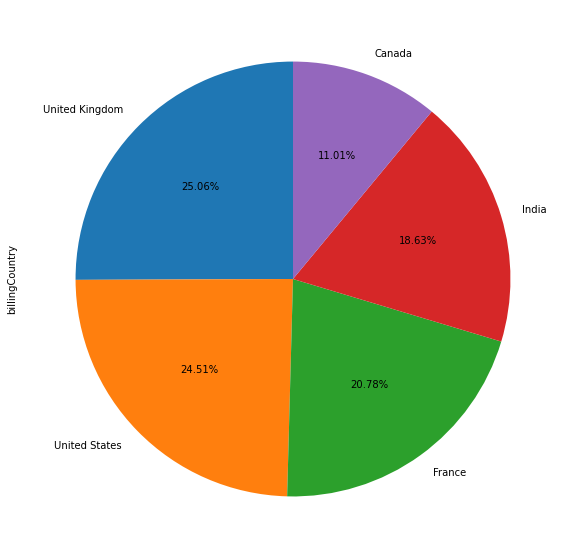

In [9]:
df['billingCountry'].value_counts(normalize=True).plot(kind='pie', autopct='%1.2f%%',startangle=90);

Половина всех подписок приходится на США и Великобританию. Вторую половину составляют Франция, Индия и Канада.

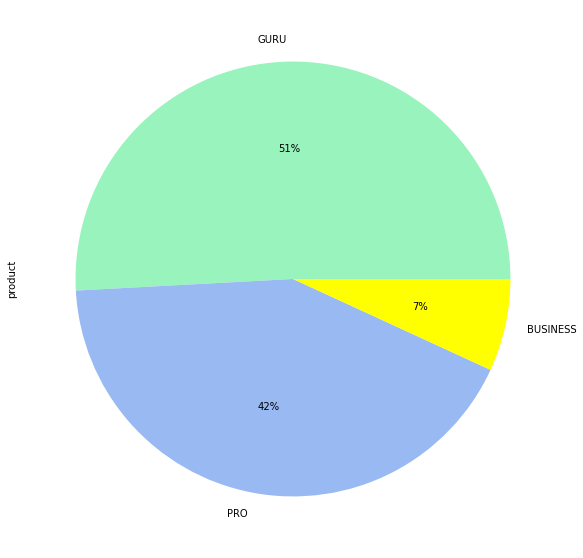

In [10]:
colors = ['#99f3bd', '#99b9f3',   'yellow']
df['product'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=colors);

In [11]:
# Распределение по продуктам
df['product'].value_counts()

GURU        19576
PRO         16279
BUSINESS     2643
Name: product, dtype: int64

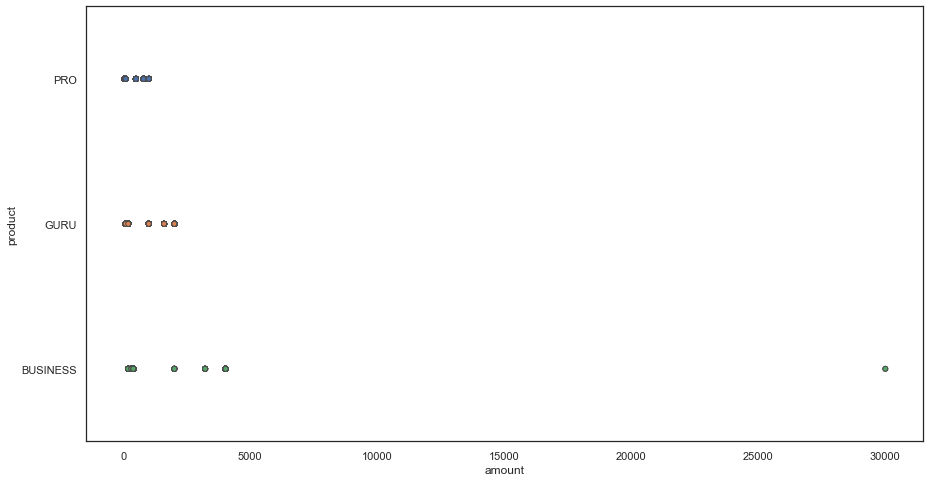

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.stripplot(x = df["amount"], y = df["product"], jitter=False, linewidth=1);

Есть выброс в районе 30000 за подписку

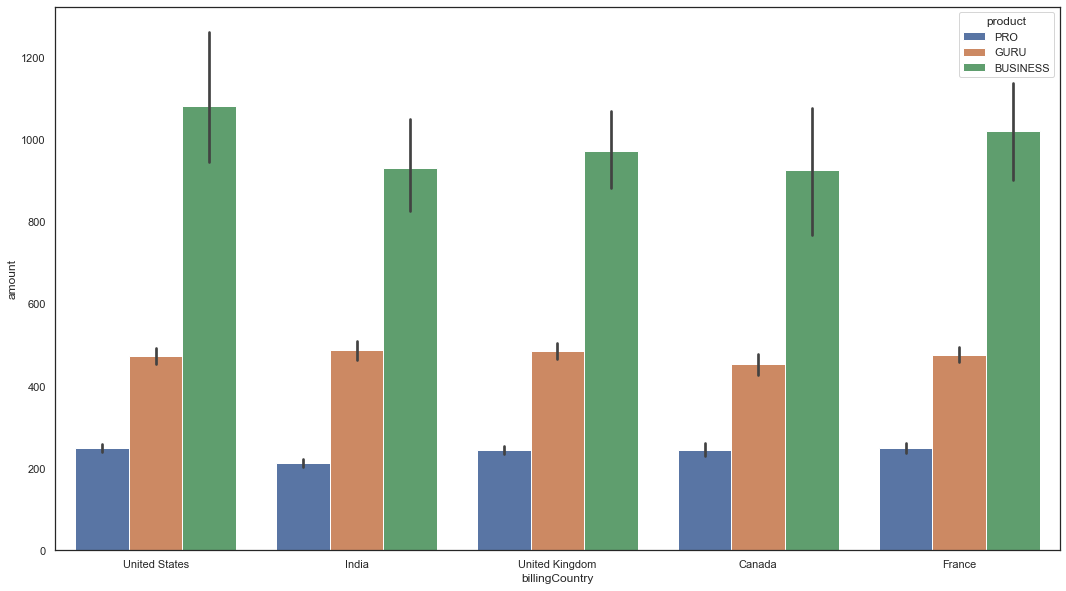

In [66]:
sns.barplot(x="billingCountry", hue="product", y="amount", data=df);

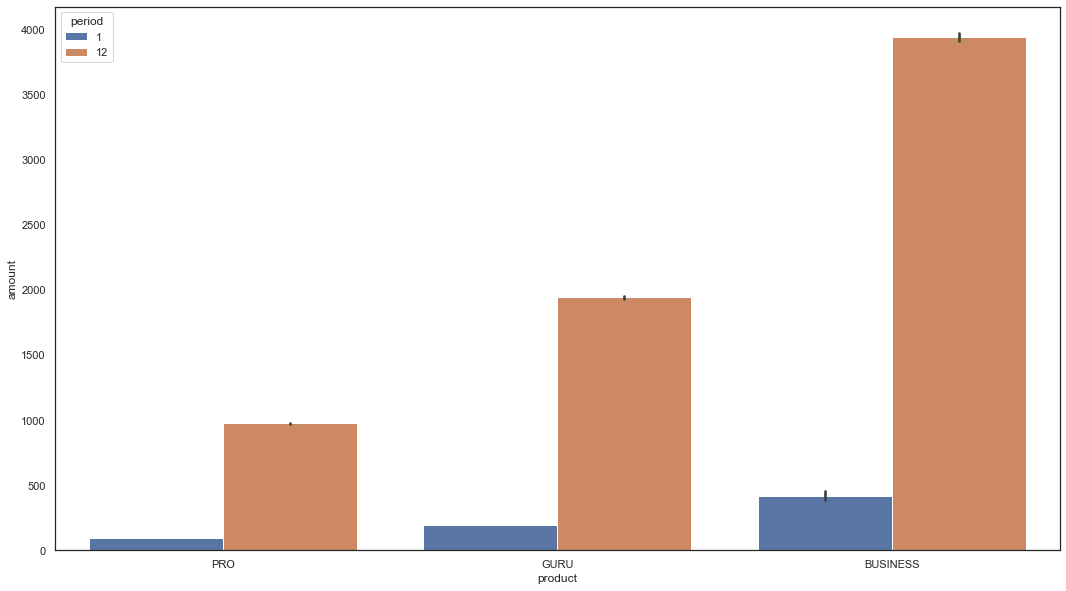

In [67]:
sns.barplot(x="product", hue="period", y="amount", data=df);

Большая часть подписок по продуктам оформляется на 1 месяц. Это характерно для всех продуктов.

# Предобработка и первичный анализ данных

In [13]:
df['datetime'] = df['transactionTime'].astype('int').astype("datetime64[s]")

In [14]:
df['datetime'].describe()

count                   38498
unique                  38263
top       2017-12-25 01:12:03
freq                        5
first     2015-01-04 01:25:01
last      2018-01-01 00:51:39
Name: datetime, dtype: object

In [16]:
df['year'] = df['datetime'].dt.year

In [17]:
df = df.set_index('userId')

In [18]:
# Дата оформления 1-ой подписки
df['first_date_subs'] = df.groupby('userId')['datetime'].min()

In [19]:
# Когорта определяется месяцем первой подписки на сервис
df['cohort_group'] = df.groupby(level=0)['first_date_subs'].min().apply(lambda x: x.strftime('%Y-%m'))

In [20]:
# Веделим в отдельный признак период офрмления подписки: Год(12) или месяц(1)
df['is_period_YEAR'] = np.where(df.period == 12, 'Y', 'N')

In [21]:
df['is_period_YEAR'].value_counts().to_frame()

,is_period_YEAR
N,32239
Y,6259


Было активировано примерно 6300 годовых подписок.

In [22]:
df['is_period_YEAR'].value_counts(normalize=True).to_frame()

,is_period_YEAR
N,0.83742
Y,0.16258


In [29]:
df.groupby('is_period_YEAR')['amount'].sum().to_frame().round(5)

,amount
is_period_YEAR,
N,5393796.95
Y,10462939.90


При этом общая сумма годовых подписок составляет 10 млн, а ежемесячных 5 млн

**15% пользователей оформляли годовую подписку. Это может косвенно говорить о том, что у клиентов входитт в привычку использовать приложение. Повляиять на офрмление годовой подписки у лояльных пользователей может скидка** 

In [75]:
# Нумерация периодов повторных подписок пользователя

def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

df = df.groupby(level=0).apply(cohort_period)

In [76]:
df = df.reset_index()

In [77]:
df.head(20)

,userId,billingCountry,transactionTime,product,price,amount,period,datetime,first_date_subs,cohort_group,is_period_YEAR,cohort_period
0,41851,United States,1420334701,PRO,99.99,1007.90,12,2015-01-04 01:25:01,2015-01-04 01:25:01,2015-01,Y,1
1,13575,India,1420383152,PRO,99.99,99.99,1,2015-01-04 14:52:32,2015-01-04 14:52:32,2015-01,N,1
2,13575,India,1470322352,GURU,199.99,199.99,1,2016-08-04 14:52:32,2015-01-04 14:52:32,2015-01,N,2
3,13575,India,1473000752,GURU,199.99,199.99,1,2016-09-04 14:52:32,2015-01-04 14:52:32,2015-01,N,3
4,13575,India,1475592752,GURU,199.99,199.99,1,2016-10-04 14:52:32,2015-01-04 14:52:32,2015-01,N,4
5,73971,India,1420461487,PRO,99.99,99.99,1,2015-01-05 12:38:07,2015-01-05 12:38:07,2015-01,N,1
6,80119,United States,1421010897,GURU,199.99,2015.90,12,2015-01-11 21:14:57,2015-01-11 21:14:57,2015-01,Y,1
7,80119,United States,1497215697,GURU,199.99,100.00,1,2017-06-11 21:14:57,2015-01-11 21:14:57,2015-01,N,2
8,80119,United States,1499807697,GURU,199.99,100.00,1,2017-07-11 21:14:57,2015-01-11 21:14:57,2015-01,N,3
9,90456,United States,1421020614,GURU,199.99,2015.90,12,2015-01-11 23:56:54,2015-01-11 23:56:54,2015-01,Y,1


Далее все расчеты проведены по полному датасету, т.е учитываются как месячные подписки так и годовые. В некоторых расчетах, например, retention это не совсем верно, т.к, если пользователь оформил подписку на год, то логично, что в след.месяце он ее он будет являться активным, но не будет учтен при расчете retention. Вопрос как учесть годовые подписки.


## Анализ данных

In [312]:
# Среднее количество годовых периодов подписок на пользователя
df.query('is_period_YEAR=="Y"').groupby('userId')['transactionTime'].count().mean()

1.0982628531321283

In [313]:
# Среднее количество месячных периодов продления на пользователя
df.query('is_period_YEAR=="N"').groupby('userId')['transactionTime'].count().mean()

1.7576600152655109

В среднем пользователь делать только около 2-х периодов продления подписки

### Средняя сумма подписки по годам

In [ ]:
df_new = df.copy().set_index('datetime')

In [199]:
AOV_year = pd.DataFrame(df_new.groupby([df_new.index.year])['amount'].sum())

AOV_year['AOV'] = pd.DataFrame(df_new.groupby([df_new.index.year])['amount'].mean())
AOV_year['change'] = AOV_year['AOV'].pct_change()*100
AOV_year

,amount,AOV,change
datetime,,,
2015,9.080464e+05,379.459419,NaN
2016,4.339517e+06,383.315727,1.016263
2017,1.060897e+07,428.074613,11.676768
2018,1.999900e+02,199.990000,-53.281509


**Средняя стоимость подписки в 2016 практически не изменилась с предыдущим годом в относительном выражении. Средння стоимость подписки в 2017 составила 428, увеличение на 12% относительно предыдущего года**

#### Динамика средней суммы подписки 

In [160]:
mon_KPI = pd.DataFrame(df_new.groupby([df_new.index.year,df_new.index.month])['amount'].sum())

In [200]:
mon_KPI['Monthly_growth'] = mon_KPI['amount'].pct_change()

In [201]:
mon_KPI['monthly_average_amount'] =  pd.DataFrame(df_new.groupby([df_new.index.year,df_new.index.month])['amount'].mean())

In [202]:
mon_KPI.index.set_names(['Year', 'Month'], inplace = True)

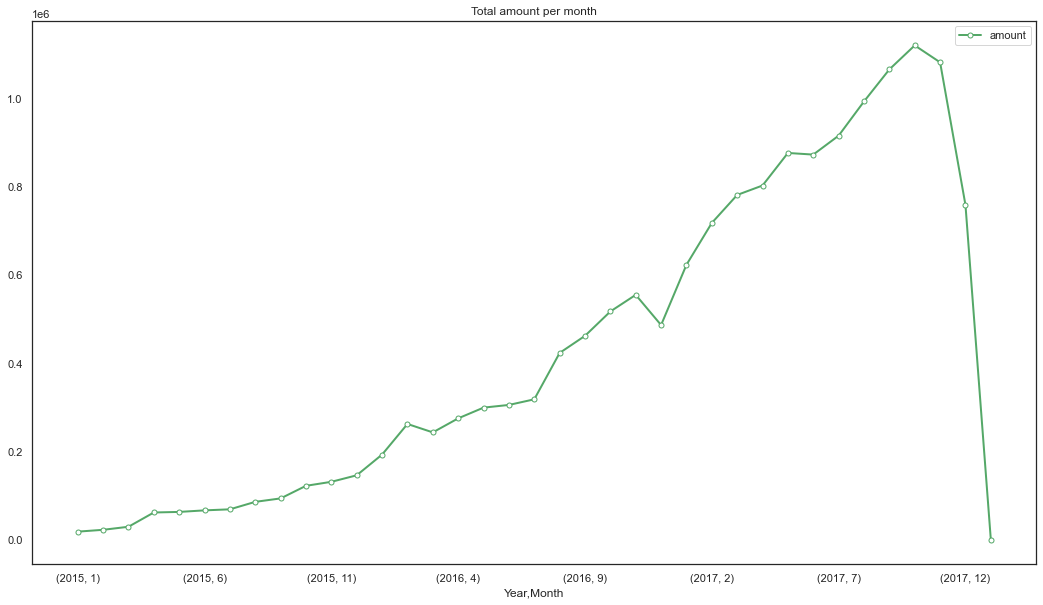

In [203]:
mon_KPI.plot.line(y='amount', 
         title='Total amount per month', 
         color = 'g',
         marker='o', 
         markersize=5, 
         linewidth=2,
         markerfacecolor='white');

**На протяжении всех перидов (за исключением 2018 года) наблдюдается рост общей месячной выручки с несколькими падениями (в марте 2016, январе и декабре 2017). Заментный рост наблюдается с начала 2017 года.**

In [204]:
import matplotlib.ticker as mtick

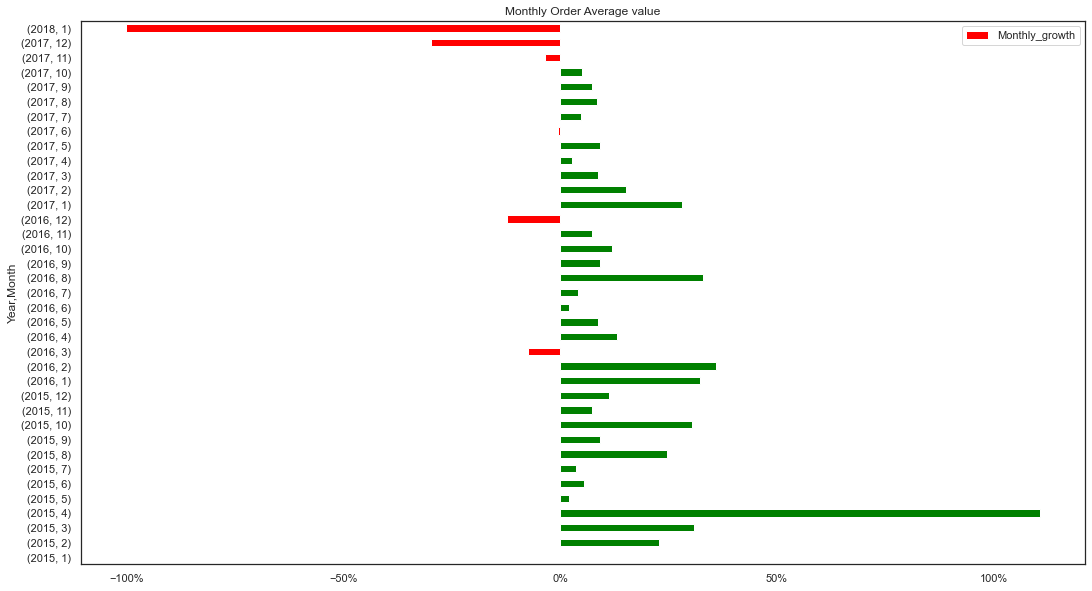

In [329]:
mon_KPI['positive'] =  mon_KPI.Monthly_growth > 0
ax = mon_KPI.plot.barh(y='Monthly_growth', title='Monthly Order Average value', color= mon_KPI.positive.map({True: 'green', False: 'red'}))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,
                                   decimals=None,
                                   symbol='%'));

**На протяжении всех перидов (за исключением 2018 года) наблдюдается рост средней суммы подписки в относительном выражении. Наибольший рост средней суммы подписки в относительном выражении  произошел в феврале 2015 и составил более 100% к предыдущему месяцу. Было несколько падений от 7 до 30%**

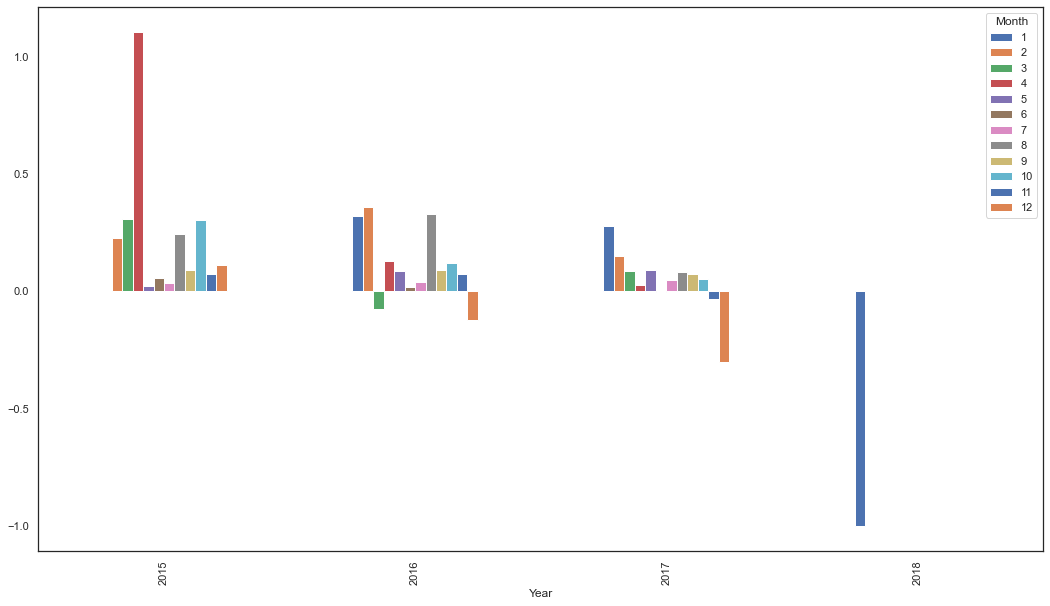

In [351]:
mon_KPI['Monthly_growth'].unstack().plot.bar();

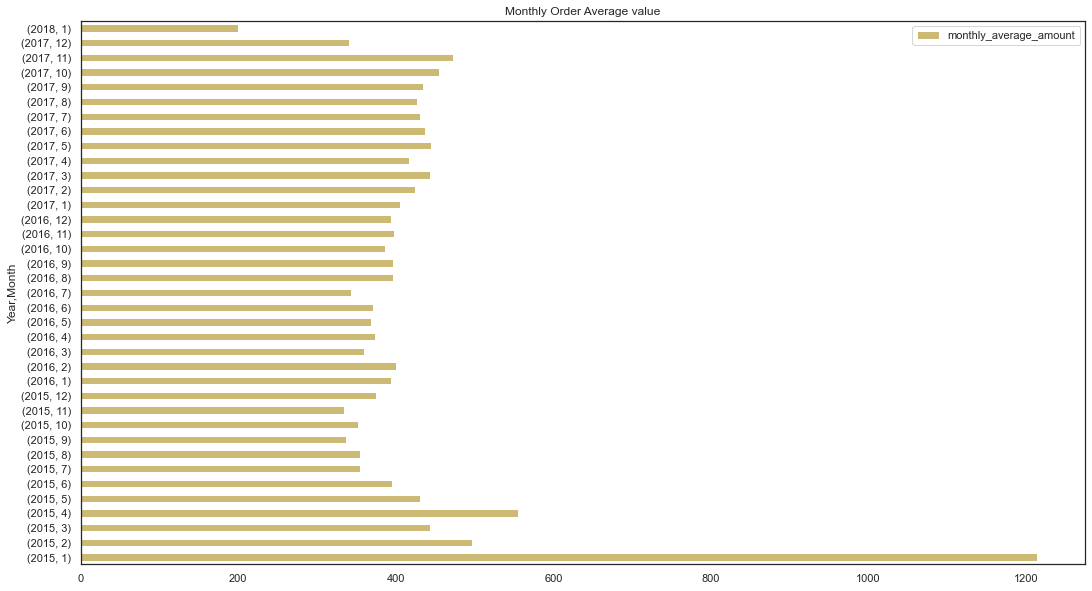

In [178]:
mon_KPI.plot.barh(y='monthly_average_amount',title='Monthly Order Average value',  color = 'y');

**Максимальная средняя сумма подписки была в начале исследуемых данных и составляла примерно 1200. В дальнейших периодах средняя сумма была примерно в районе 350. Наблюдается рост  с 2017 года примерно до 450**

#### Средняя сумма подписки по странам

In [212]:
aov_yea = (
    df
    .groupby(['billingCountry', 'year'], as_index=False)['amount']
    .mean()
)

In [213]:
aov_yea.sort_values(['billingCountry','year'], inplace = True, ascending=[True, True])

In [214]:
aov_yea['pct_ch'] = (aov_yea.groupby('billingCountry')['amount']
                                  .apply(pd.Series.pct_change)*100)

In [215]:
aov_yea

,billingCountry,year,amount,pct_ch
0,Canada,2015,338.565344,NaN
1,Canada,2016,373.740395,10.389442
2,Canada,2017,408.537632,9.310537
3,France,2015,374.818762,NaN
4,France,2016,384.449905,2.569547
5,France,2017,439.831109,14.405311
6,France,2018,199.990000,-54.530274
7,India,2015,345.492854,NaN
8,India,2016,371.101262,7.412138
9,India,2017,392.961872,5.890740


**
1. Средний рост средней суммы подписки в Канаде составляет 10% от года к году, в абсолютном выражении средняя мумма подписки выросла с 340 до 410.
2. Во Франции в 2016 году рост был всего на 2,5%, в в 2017 уже на 15%. 2018 год не считаем, т.к вероятно там недостаточно данных, этим и обусловлено такое падение.
3. Рост в Индии был в районе 6%
4. Великобритания в 2016 году показала падение, хоть и не значительное, по  средней сумме подписки. Зато в следующем году наблюдался рост на 15%.
5. США в 2016 году также проселана 5% с последующим ростом в 2017 году

Самая высокая средняя сумма подписки наблюдается в Великобритании в 2107 году, за ней идут Франция с суммой 439 и США - 435, далее остальные страны.

### Когортный анализ

In [78]:
# Выручка по пользователям когорты
user_data_cohorts = df.groupby(['cohort_group','userId']).agg({'amount':'sum'})
user_data_cohorts = user_data_cohorts.rename(columns={'amount':'total_amount'})
user_data_cohorts

total_amount
cohort_group userId              
2015-01      4653         3015.84
             13575         699.96
             16382        2015.90
             18151         399.99
             38270        4131.89
...                           ...
2017-12      210792         99.99
             210873         99.99
             210891         99.99
             210986         99.99
2018-01      92250         199.99

[22438 rows x 1 columns]

#### Расчет суммарной выручки в разрезе когорт и периодов

In [217]:
cohorts_data = (
    df
    .groupby(['cohort_group', 'cohort_period'])
    .agg({'userId': 'nunique', 'amount': 'sum'})
    .rename(columns={'userId':'n_users', 'amount': 'total_amount'})
)
cohorts_data

n_users  total_amount
cohort_group cohort_period                       
2015-01      1                   15      18215.13
             2                   10      13903.46
             3                    6       2815.86
             4                    4        499.97
             5                    2        199.98
...                             ...           ...
2017-10      2                  319      85745.74
2017-11      1                 1479     723130.73
2017-12      1                 1904     593475.58
             2                    3        299.97
2018-01      1                    1        199.99

[323 rows x 2 columns]

In [218]:
cohort_summary = cohorts_data['total_amount'].unstack(level=0)
cohort_summary.head(10)

cohort_group,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,...,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01
cohort_period,,,,,,,,,,,,,,,,,,,,,
1,18215.13,18042.86,28262.22,57776.90,50810.18,49909.22,54152.43,69913.05,71266.53,92440.40,...,485394.78,505069.01,522963.40,554453.95,564244.40,630923.14,685565.14,723130.73,593475.58,199.99
2,13903.46,22212.79,23924.54,35435.92,28027.23,38837.29,46629.41,43341.57,58936.67,45685.10,...,102545.70,93356.12,96542.80,87223.94,108180.59,94087.59,85745.74,NaN,299.97,NaN
3,2815.86,9485.47,15436.96,17692.89,29130.48,19770.54,23326.54,35014.53,43417.48,36571.45,...,42141.94,41740.55,42410.63,32283.03,42370.00,NaN,NaN,NaN,NaN,NaN
4,499.97,4953.70,6023.62,13059.31,16803.16,9777.35,8973.45,17910.82,21798.83,28800.06,...,16527.77,14701.12,16253.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,199.98,1937.84,7944.47,12129.42,3143.78,15085.32,9359.46,7299.61,13231.10,14357.83,...,14407.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,299.98,949.94,6436.40,7497.77,2707.80,2889.81,6263.62,12075.30,12431.15,5559.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015.90,5489.76,2507.79,1429.92,799.95,7329.66,8787.56,12408.11,5553.62,6107.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4431.88,3723.75,1399.93,1707.86,7379.66,5791.70,2359.86,4495.74,8779.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,399.98,1507.87,1199.93,1807.86,1779.90,1519.91,3715.81,2299.88,3009.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


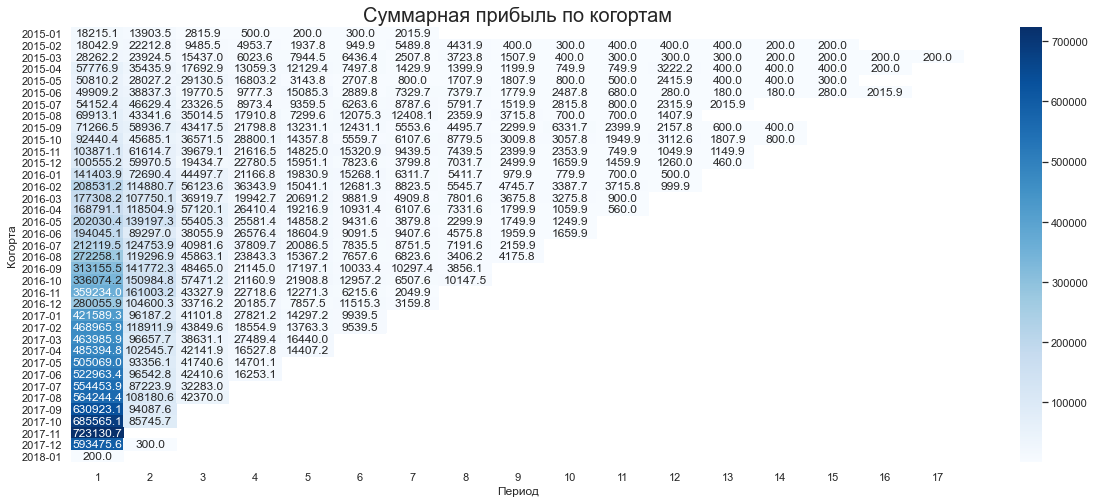

In [219]:
ax = plt.figure(figsize=(20, 8))
ax = sns.heatmap(cohort_summary.T, 
                 mask=cohort_summary.T.isnull(), 
                 annot=True, 
                 cmap='Blues', 
                 fmt='.1f')

ax.set_ylabel('Когорта')
ax.set_xlabel('Период')
ax.set_title('Суммарная прибыль по когортам', fontsize = 20);

**Самая высокая прибыль наблюдалась в когорте 2017-11 в 1 период и составила 723000$.
Самыми прибыльными когортами в 1 период оказались когорты конца 2017 года: 2017-09, 2017-10, 2017-11, 2017-12.
Если сравнить когорты того же месяца предыдущего года (2016), то рост примерно двукратный**

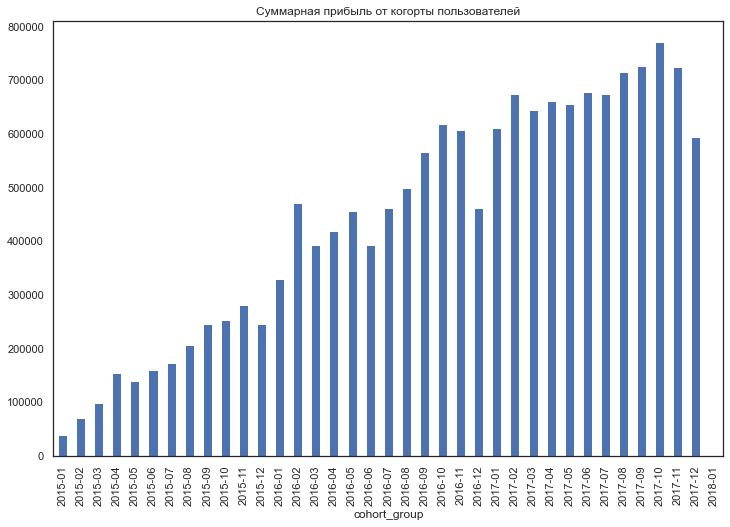

In [220]:
cohort_contrib= cohort_summary.sum(axis=0)
cohort_contrib.plot(kind='bar', figsize=(12,8), title='Суммарная прибыль от когорты пользователей');

**Исходя из графика заметно, что суммарная прибыль по когортам растет. Максимальный пик наблюдается в когорте 2017-10**

#### Расчет LTV

In [221]:
cohort_sizes = (
    cohorts_data.
    groupby(['cohort_group']).agg(coh_size = ('n_users','first'))
)
cohort_sizes.head()

,coh_size
cohort_group,
2015-01,15
2015-02,42
2015-03,60
2015-04,90
2015-05,106


In [223]:
cohorts_data = cohorts_data.reset_index().merge(
    cohort_sizes, on=['cohort_group'])

In [225]:
cohorts_data['ARPU'] = cohorts_data['total_amount'] / cohorts_data['coh_size']
cohorts_data['cum_sum'] = cohorts_data.groupby('cohort_group')['total_amount'].cumsum()
cohorts_data['LTV_cumulative'] = cohorts_data['cum_sum'] / cohorts_data['coh_size']

In [227]:
ltv_pivot = cohorts_data.pivot_table(
    index='cohort_group',
    columns='cohort_period',
    values='LTV_cumulative',
    aggfunc='sum',
) 

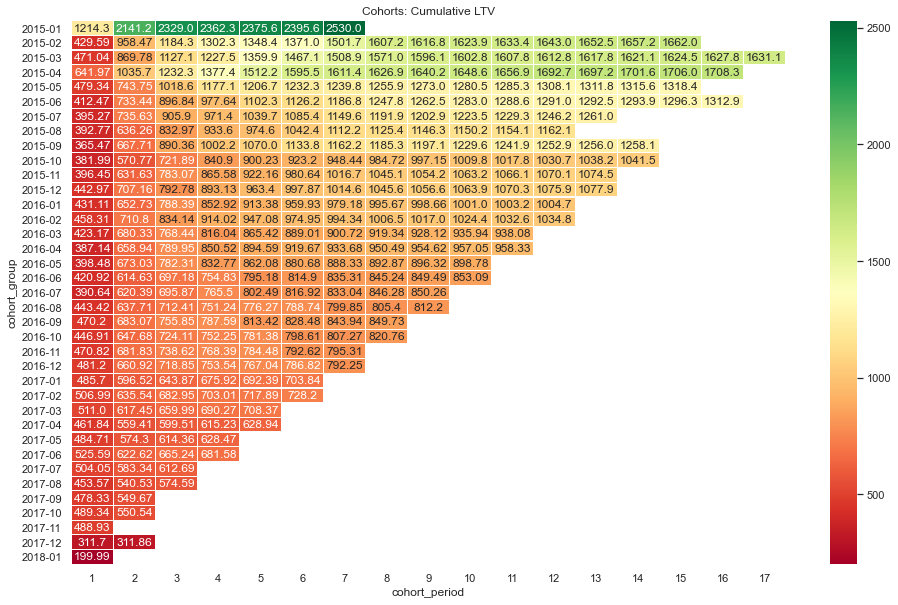

In [228]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: Cumulative LTV')
sns.heatmap(ltv_pivot, annot=True, linewidths=0.2, fmt='.5',cmap='RdYlGn'); 

**Когорта 2015-01 показывает один из самых высоких кумулятивных LTV, но срок жизни данной когорты только 7 периодов. А вот когорты следующих двух периодов хоть и имеют более низкий LTV, но при этом у них жизненный цикл 15 и 17 периодов. Это означает, что клиенты этих когорт стали лояльными к сервису и возврщаются вновь.
Также наблюдается динамика снижения LTV по всем следующим когортам и периодам**

#### ARPU на когорту

In [296]:
ARPU_pivot = cohorts_data.pivot_table(
    index='cohort_group',
    columns='cohort_period',
    values='ARPU',
    aggfunc='sum',
) 

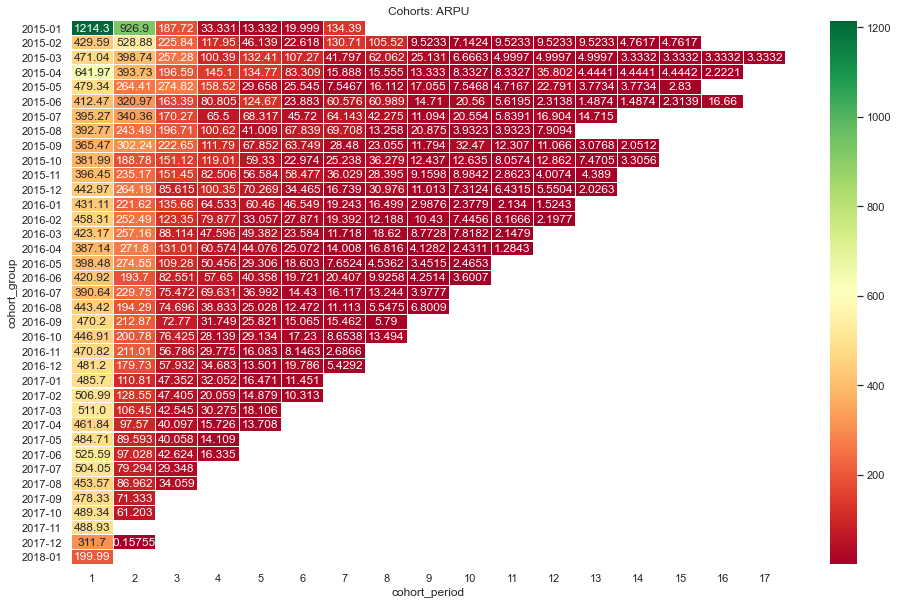

In [297]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: ARPU')
sns.heatmap(ARPU_pivot, annot=True, linewidths=0.2, fmt='.5',cmap='RdYlGn'); 

**ARPU снижается во всех когортах. Причем падения в некоторых когортах кратные. Например в когорте 2017-08 падение в 5 раз ко-второму периоду.
Снижение ARPU может говрить о том, что пользователи больше не готовы платить за продукт.**

**Средняя выручка на пользователя заметно падает во всех когортах и периодах**

#### Расчет retention(подписки на 1 и 12 периодов)

In [231]:
# Месячные подписки
df_pivot_month = df.pivot_table(
    index='cohort_group', 
    columns = 'cohort_period',
    values = 'userId',
    aggfunc = 'nunique'
)

In [232]:
cohorts_month = (
    df
    .groupby(['cohort_group','cohort_period'])
    .agg({'userId':'nunique', 'userId':'count'})
    .reset_index()
) 
cohorts_month

,cohort_group,cohort_period,userId
0,2015-01,1,15
1,2015-01,2,10
2,2015-01,3,6
3,2015-01,4,4
4,2015-01,5,2
...,...,...,...
318,2017-10,2,319
319,2017-11,1,1479
320,2017-12,1,1904
321,2017-12,2,3


In [233]:
initial_users_count = cohorts_month[cohorts_month['cohort_period'] == 1][['cohort_group', 'userId']]

In [234]:
initial_users_count = initial_users_count.rename(columns={'userId':'cohort_users'}) 

In [235]:
cohorts_month = cohorts_month.merge(initial_users_count,on='cohort_group') 

In [236]:
cohorts_month['retention'] = cohorts_month['userId']/cohorts_month['cohort_users'] 
cohorts_month

,cohort_group,cohort_period,userId,cohort_users,retention
0,2015-01,1,15,15,1.000000
1,2015-01,2,10,15,0.666667
2,2015-01,3,6,15,0.400000
3,2015-01,4,4,15,0.266667
4,2015-01,5,2,15,0.133333
...,...,...,...,...,...
318,2017-10,2,319,1401,0.227695
319,2017-11,1,1479,1479,1.000000
320,2017-12,1,1904,1904,1.000000
321,2017-12,2,3,1904,0.001576


In [237]:
retention_pivot = cohorts_month.pivot_table(
    index='cohort_group',
    columns='cohort_period',
    values='retention',
    aggfunc='sum',
) 

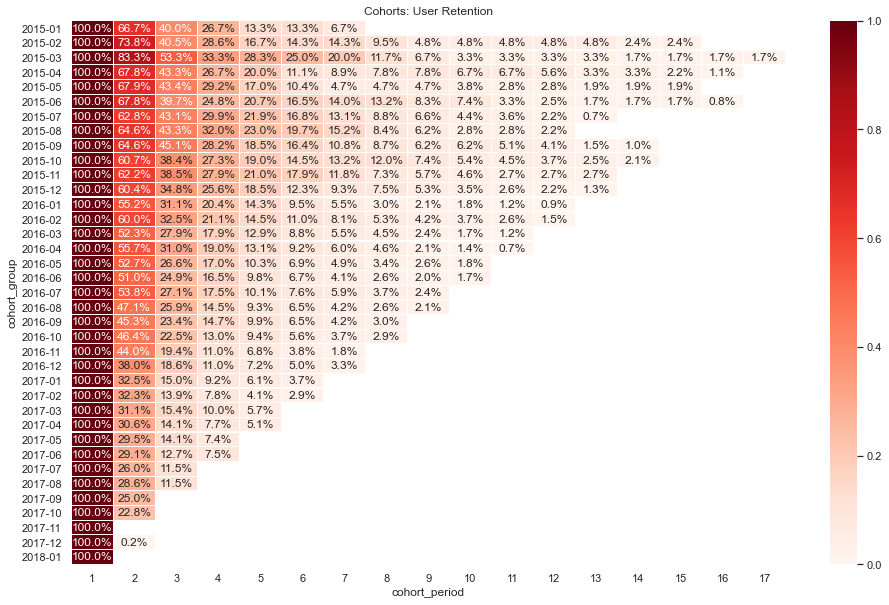

In [238]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, linewidths=0.2, fmt='.1%', vmin=0.0, vmax=1,cmap='Reds'); 

In [132]:
Retention2 = cohorts_month[cohorts_month['cohort_period'] == 2]['retention'].mean()
Retention3 = cohorts_month[cohorts_month['cohort_period'] == 3]['retention'].mean()
Retention4 = cohorts_month[cohorts_month['cohort_period'] == 4]['retention'].mean()
Retention5 = cohorts_month[cohorts_month['cohort_period'] == 5]['retention'].mean()

print('Cредний Retention Rate на второй месяц «жизни» когорт составляет: {:.1f} %'.format(Retention2*100))
print('Cредний Retention Rate на третий месяц «жизни» когорт составляет: {:.1f} %'.format(Retention3*100))
print('Cредний Retention Rate на четверты месяц «жизни» когорт составляет: {:.1f} %'.format(Retention4*100))
print('Cредний Retention Rate на четверты месяц «жизни» когорт составляет: {:.1f} %'.format(Retention5*100))

Cредний Retention Rate на второй месяц «жизни» когорт составляет: 48.3 %
Cредний Retention Rate на третий месяц «жизни» когорт составляет: 28.8 %
Cредний Retention Rate на четверты месяц «жизни» когорт составляет: 19.4 %
Cредний Retention Rate на четверты месяц «жизни» когорт составляет: 13.8 %


**Retention также стремительно падает в когортах. Наиболее высокий Retention на второй месяц показывает когорта 2015-02., т.е практически 85% процентов оплатили подписку после первого месяца использования.
В среднем на второй месяц использования приложения мы теряем примерно 50% пользователей. На третий практически 2/3.
В целом можно сказать, что стремительно теряет пользователей начиная со второго месяца. Необходимо разработать и применить инструменты для удержания клиентов**

In [232]:
# # Годовые подписки
# df_pivot_year = df.query('is_period_YEAR=="Y"').pivot_table(
#     index='cohort_group', 
#     columns = 'cohort_period',
#     values = 'userId',
#     aggfunc = 'nunique'
# )

In [222]:
# df.query('is_period_YEAR=="Y" and userId==4653')

,userId,billingCountry,transactionTime,product,price,amount,period,datetime,date,month,week,first_date_subs,cohort_group,is_period_YEAR,cohort_period
22,4653,United States,1489315569,GURU,199.99,2015.9,12,2017-03-12 10:46:09,2017-03-12,2017-03-01,2017-03-09,2015-01-12,2015-01,Y,7


In [226]:
# df_pivot_year


In [227]:
# cohorts_year = df.query('is_period_YEAR=="Y"').groupby(['cohort_group','cohort_period']).agg({'userId':'nunique'}).reset_index() 
# cohorts_year

In [228]:
# initial_users_year = cohorts_year[cohorts_year['cohort_period'] == 1][
#     ['cohort_group', 'userId']
# ]

In [229]:
# initial_users_year = initial_users_year.rename(columns={'userId':'cohort_users'}) 

In [230]:
# cohorts_year = cohorts_year.merge(initial_users_year,on='cohort_group') 

In [231]:
# cohorts_year['retention'] = cohorts_year['userId']/cohorts_year['cohort_users'] 
# cohorts_year

In [224]:
# retention_pivot_year = cohorts_year.pivot_table(
#     index='cohort_group',
#     columns='cohort_period',
#     values='retention',
#     aggfunc='sum',
# ) 

In [225]:
# sns.set(style='white')
# plt.figure(figsize=(16, 10))
# plt.title('Cohorts: User Retention')
# sns.heatmap(retention_pivot_year, annot=True, linewidths=0.2, fmt='.1%', vmin=0.0, vmax=1,cmap='Reds'); 

In [302]:
coh = df.groupby(['cohort_group','cohort_period']).agg(
    n_orders=('userId', 'count'),
    n_users = ('userId', 'nunique')
).reset_index()

In [135]:
initial_users_count = coh[coh['cohort_period'] == 1][['cohort_group','n_users']]
initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_subs'})
initial_users_count

coh = coh.merge(initial_users_count,on='cohort_group')

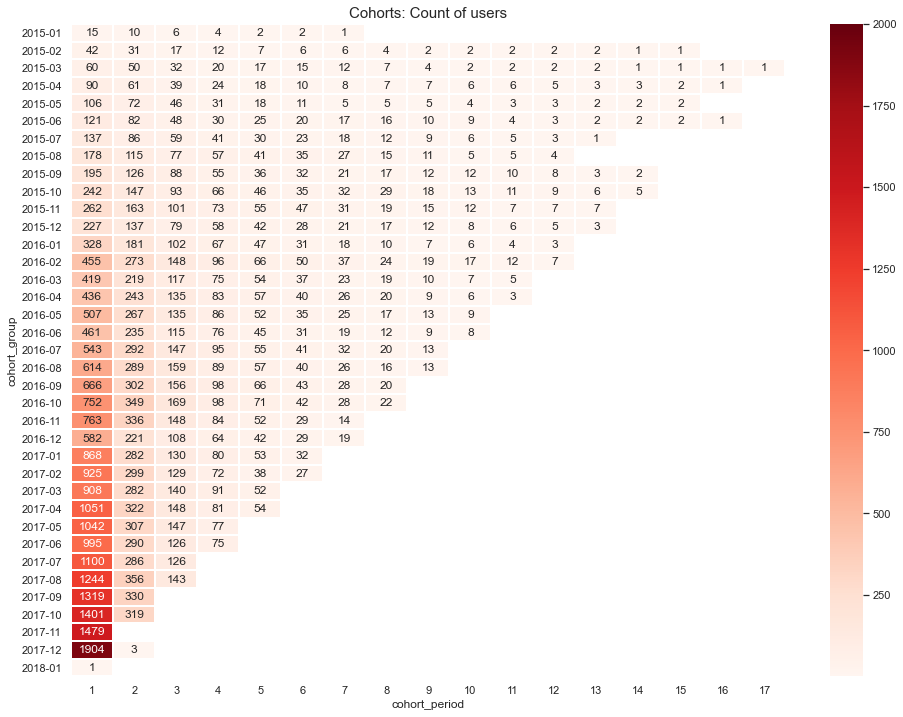

In [301]:
# количество заказов в каждой когорте
orders_pivot = coh.pivot_table(index='cohort_group',columns='cohort_period',values='n_orders',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(16, 12))
plt.title('Cohorts: Count of users', fontsize = 15)

# подписи по оси у
y_axis_labels = orders_pivot.index
sns.heatmap(orders_pivot, annot=True, linewidths=1, vmax = 2000, fmt='.0f',
            cmap="Reds", yticklabels=y_axis_labels);

**Из представленного выше графика можно заметить, что количество пользователей растет, но при этом средний чек не такой высокий как в предыдущих периодах. Это может говорить о том, что клиенты предпочитать выбирать более дешевые тарифы.**

In [242]:
# сгруппируем заказы по месяцам и вычислим средний чек за месяц
revenue_mean = df.groupby('cohort_group').agg({'amount':'mean'}).reset_index()
revenue_by_product = df.pivot_table(index='cohort_group',columns = 'product', values='amount').reset_index()

revenue_by_product = revenue_mean.merge(revenue_by_product, on='cohort_group')
revenue_by_product.sort_values(by = 'amount', ascending = False).head()

,cohort_group,amount,BUSINESS,GURU,PRO
0,2015-01,948.757000,3305.518000,853.221579,325.717500
3,2015-04,530.151621,1781.494231,615.863186,250.546887
1,2015-02,509.519124,1404.409444,482.093725,293.205441
34,2017-11,488.932204,1261.938806,538.024880,273.013282
29,2017-06,456.372759,1092.234082,491.640952,234.079236


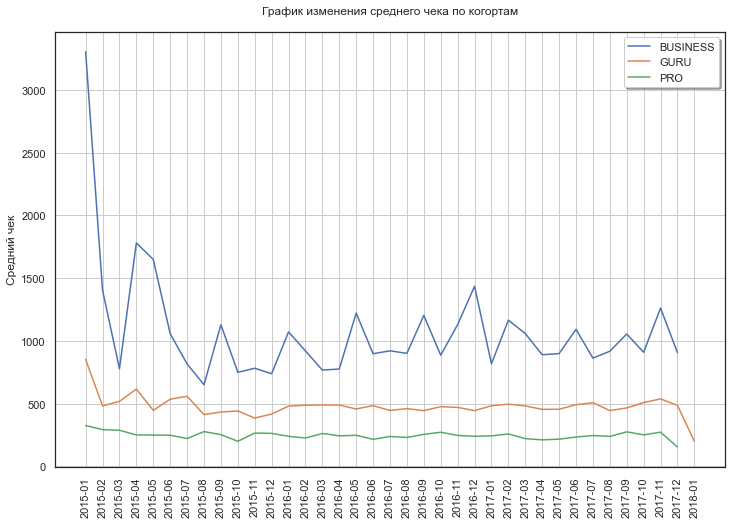

In [243]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 8))
plt.ylabel('Средний чек')
plt.title('График изменения среднего чека по когортам'+ '\n')

ax1.plot(revenue_by_product['cohort_group'],revenue_by_product['BUSINESS'])
ax1.plot(revenue_by_product['cohort_group'],revenue_by_product['GURU'])
ax1.plot(revenue_by_product['cohort_group'],revenue_by_product['PRO'])
ax1.grid()
plt.xticks(rotation=90)
ax1.legend(['BUSINESS','GURU', 'PRO'],loc='best', ncol=1, shadow=True);

**В подписках GURU и PRO средний чек по когортам довольно стабильный, в подписке BUSINESS видна волатильность.**

In [244]:
# сгруппируем подписки и вычислим средний чек по странам
revenue_mean = df.groupby('cohort_group').agg({'amount':'mean'}).reset_index()
revenue_by_country = df.pivot_table(index='cohort_group',columns = 'billingCountry', values='amount').reset_index()

revenue_by_country = revenue_mean.merge(revenue_by_country, on='cohort_group')
revenue_by_country.sort_values(by = 'amount', ascending = False).head()

,cohort_group,amount,Canada,France,India,United Kingdom,United States
0,2015-01,948.757000,1370.596667,603.945000,159.990000,2606.198571,590.750435
3,2015-04,530.151621,825.756500,506.440851,477.389792,479.301538,572.733099
1,2015-02,509.519124,421.150588,358.262857,696.497308,658.296531,234.303871
34,2017-11,488.932204,410.118836,518.114323,457.329709,502.531435,474.780050
29,2017-06,456.372759,364.795793,488.940852,454.948571,458.667911,451.867386


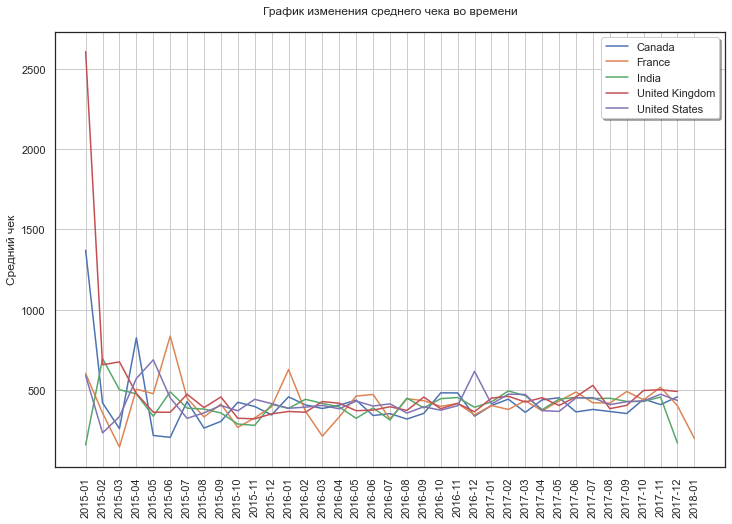

In [143]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 8))
plt.ylabel('Средний чек')
plt.title('График изменения среднего чека во времени'+ '\n')

ax1.plot(revenue_by_country['cohort_group'], revenue_by_country['Canada'])
ax1.plot(revenue_by_country['cohort_group'], revenue_by_country['France'])
ax1.plot(revenue_by_country['cohort_group'], revenue_by_country['India'])
ax1.plot(revenue_by_country['cohort_group'], revenue_by_country['United Kingdom'])
ax1.plot(revenue_by_country['cohort_group'], revenue_by_country['United States'])
ax1.grid()
plt.xticks(rotation=90)
ax1.legend(['Canada','France', 'India', 'United Kingdom', 'United States'],loc='best', ncol=1, shadow=True);

**Средний чек по странам различается не очень значительно. Более волатильная - Франция.**

#### Расчет retention в разрезе стран, продуктов и периодов.

In [245]:
def calc_retention_rate(s):
    """
    Вход: 
        s: Значения подписчика платящего n-циклов
    Выход:
         Считается Retenton для каждого цикла
    """
    r = s.iloc[::-1].cumsum().iloc[::-1]
    return r/r.iloc[0]

def retention_rate_by(colname):
    """
    step 1. Подписчики группируются по странам, тарифам и т.д
    step 2. Для каждой группы считается количество подписчиков платящих n-периодов
    step 3. Считается Retenton для каждой группы
    """
    counts = df.groupby(colname).apply(lambda df: df.cohort_period.value_counts()).unstack()
    return counts.apply(calc_retention_rate, axis=1).T

In [246]:
retention_rate_by_country = retention_rate_by('billingCountry')
retention_rate_by_country

billingCountry,Canada,France,India,United Kingdom,United States
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.428167,0.315461,0.404238,0.466991,0.457340
3,0.234961,0.142232,0.221773,0.267178,0.253736
4,0.147440,0.075366,0.135907,0.168722,0.154001
5,0.095305,0.041495,0.087817,0.109649,0.095601
6,0.061807,0.023497,0.058266,0.072028,0.059883
7,0.041755,0.014623,0.038054,0.046430,0.036248
8,0.028073,0.009124,0.024115,0.029951,0.022152
9,0.018636,0.005874,0.014079,0.018551,0.013672
10,0.012739,0.003750,0.008782,0.011089,0.008797


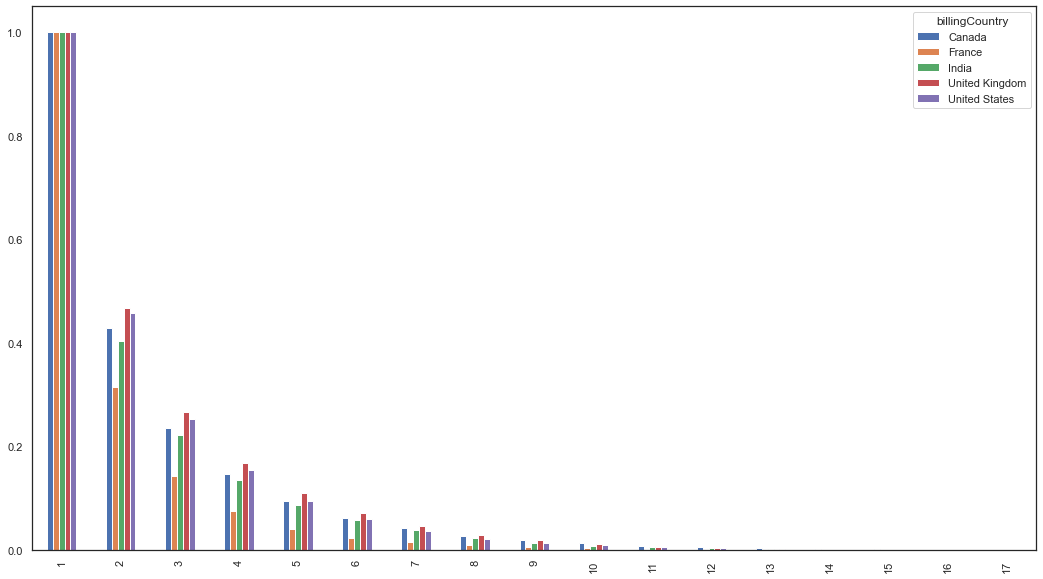

In [247]:
retention_rate_by_country.plot(kind='bar');

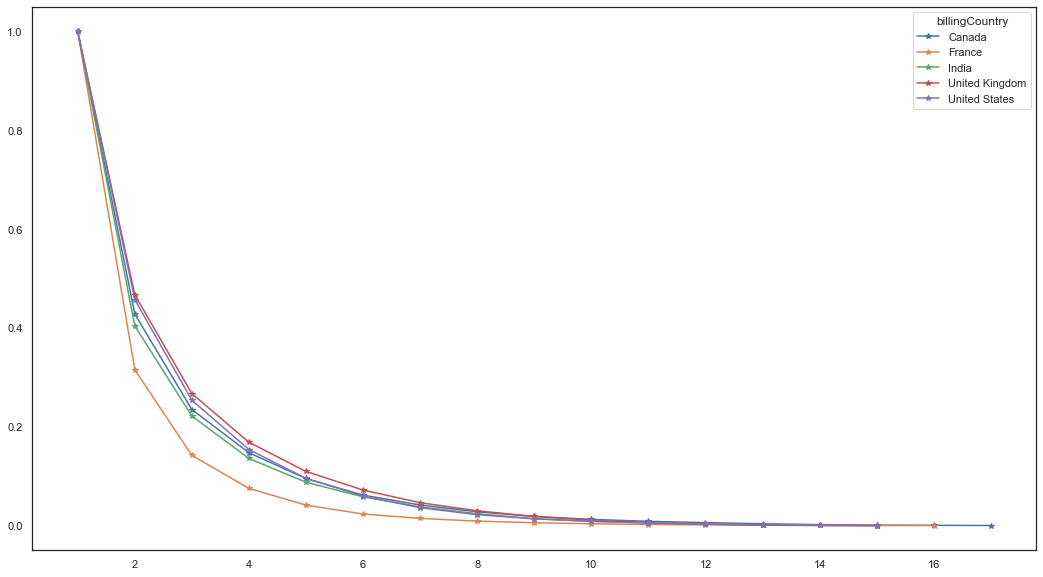

In [248]:
retention_rate_by_country.plot(marker='*');

**Более высокий отток наблюдаем у Франции. На второй месяц остается только 30% процентов подписчиков. У других стран retention примеоно в одном диапазоне**

In [249]:
retention_rate_by_product = retention_rate_by('product')

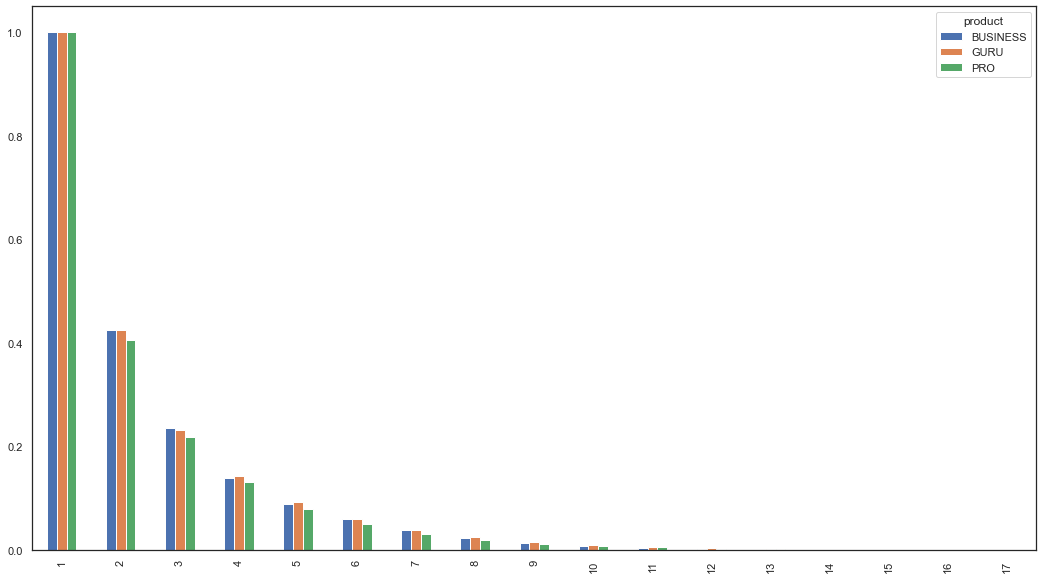

In [250]:
retention_rate_by_product.plot(kind='bar');

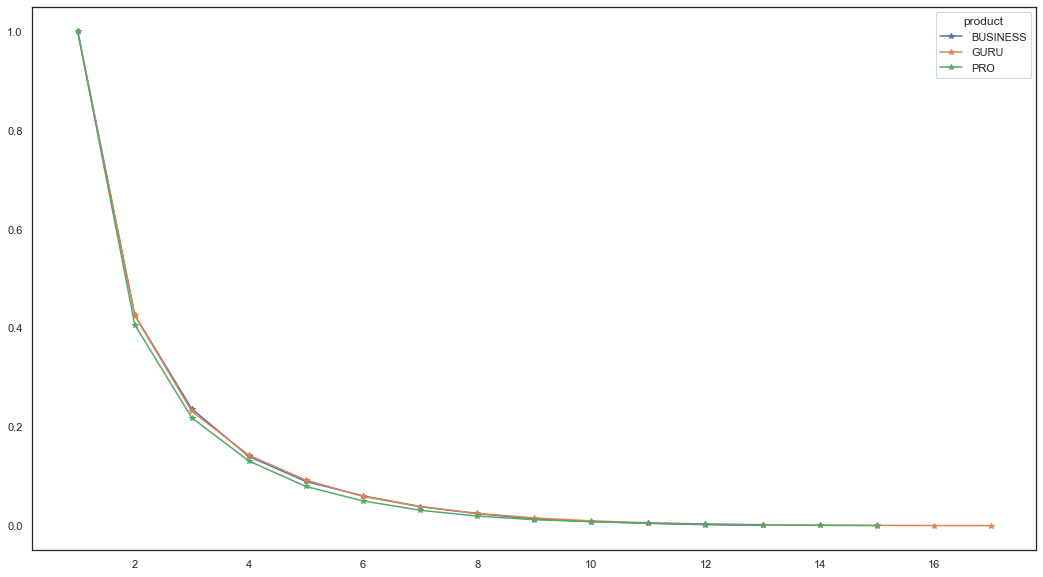

In [251]:
retention_rate_by_product.plot(marker='*');

**Значительным отличий  в возвращаемости клиентов  в зависимости от продукта не наблюдается. На второй период остается 40%, на третий падений в 2 раза - 20% и т.д**

# RFM-анализ.

**RFM — это сегментация клиентов для измерения их потребительской ценности.**

recency: насколько давно была совершена последняя покупка каждого клиента.  
frequency: сколько раз покупатель совершал покупки за период.  
monetary_value: сколько клиент потратил за период  

In [255]:
# Определим последнюю дату в датафрейме
last_date = df['datetime'].max()
last_date

Timestamp('2018-01-01 00:51:39')

In [257]:
# Сформируем признаки Recency, Frequency, Monetary value
rfm_df = df.groupby('userId').agg({'datetime': lambda x: (last_date - x.max()).days, # Дней с последней даты
                                    'transactionTime': lambda x: x.count(), # Количество заказов
                                    'amount': lambda x: x.sum()}) # Сумма по заказам

rfm_df.columns = ['recency', 'frequency', 'monetary_value']

In [259]:
rfm_df

,recency,frequency,monetary_value
userId,,,
2,678,1,2015.90
13,808,1,199.99
18,546,1,49.99
29,94,1,199.99
33,94,2,499.98
...,...,...,...
210792,6,1,99.99
210873,6,1,99.99
210891,6,1,99.99


In [258]:
# Видим выброс
df.query('userId==123321121')

,userId,billingCountry,transactionTime,product,price,amount,period,datetime,first_date_subs,cohort_group,is_period_YEAR,cohort_period,year
18755,123321121,United States,1481760000,BUSINESS,399.99,30000.0,1,2016-12-15 00:00:00,2016-12-15,2016-12,N,1,2016
18756,123321121,United States,1514163661,BUSINESS,399.99,30000.0,1,2017-12-25 01:01:01,2016-12-15,2016-12,N,2,2017


In [260]:
# Проверим размерность
rfm_df.shape[0], df['userId'].nunique()

(22438, 22438)

In [261]:
quantile = rfm_df.quantile([0.25, 0.5, 0.75])
quantile

,recency,frequency,monetary_value
0.25,78.0,1.0,199.98
0.50,186.0,1.0,199.99
0.75,350.0,2.0,1007.90


In [262]:
def r_class(value, params, quant_table):
    if value <= quant_table[params][0.25]:
        return 1
    elif value <= quant_table[params][0.50]:
        return 2
    elif value <= quant_table[params][0.75]:
        return 3
    else:
        return 4

In [263]:
def fm_class(value, params, quant_table):
    if value <= quant_table[params][0.25]:
        return 4
    elif value <= quant_table[params][0.50]:
        return 3
    elif value <= quant_table[params][0.75]:
        return 2
    else:
        return 1

In [264]:
rfm_segmentation = rfm_df.copy()

In [265]:
rfm_segmentation['r_quartile'] = rfm_segmentation['recency'].apply(r_class, args=('recency', quantile))
rfm_segmentation['f_quartile'] = rfm_segmentation['frequency'].apply(fm_class, args=('frequency', quantile))
rfm_segmentation['m_quartile'] = rfm_segmentation['monetary_value'].apply(fm_class, args=('monetary_value', quantile))

In [266]:
rfm_segmentation['RFM'] = rfm_segmentation['r_quartile'].map(str) \
                        + rfm_segmentation['f_quartile'].map(str) \
                        + rfm_segmentation['m_quartile'].map(str) 

In [268]:
rfm_segmentation.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFM
userId,,,,,,,
2,678,1,2015.90,4,4,1,441
13,808,1,199.99,4,4,3,443
18,546,1,49.99,4,4,4,444
29,94,1,199.99,2,4,3,243
33,94,2,499.98,2,2,2,222


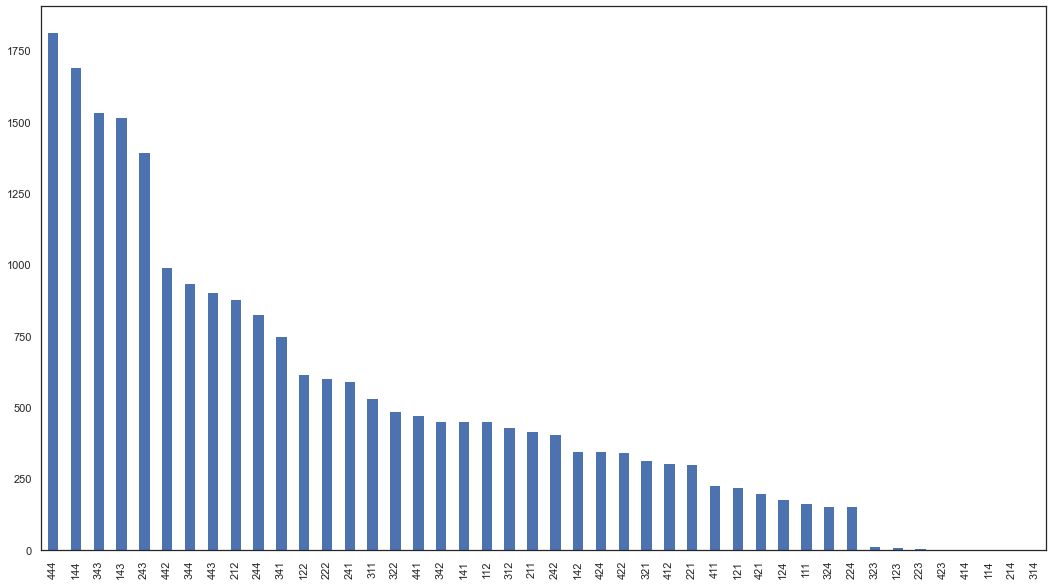

In [269]:
# Cоотношение категорий
rfm_segmentation.RFM.value_counts().plot.bar();

Преобладаем категория 444, в тоже время большое количество клиентов 144 на грани ухода.

RFM = 111 — имеют высокий чек, часто покупают и совершали покупки недавно. Самые лояльным и активные пользователи.  
RFM = 444 — имеют низкий чек, покупают нечасто и давно совершали покупки. Скорее всего потерянные клиенты. Возможно не стоит предпринять действия по их возврату, если цена возврата выше ожидаемой прибыли.

R=4, F=1 - Новые покупатели R=4, F=4, M=3 - Лояльные покупатели

R=1-2, F=2-4, M=3-4 — лояльные пользователи на грани ухода. Стоит предложить им скидку, чтобы стимулировать совершить повторный заказ.   
R=3-4, F=1, M=1-2-3-4 — пользователи недавно совершили платеж.

Дополнительно можно сделать:

RF-анализ. Анализ по давности и частоте покупок. Показывает, как часто клиенты совершают покупки за анализируемый период. Позволяет выявить клиентов, которые недавно что-то купили и сотрудничают с компанией постоянно.

RM-анализ. Распределение покупателей по параметрам Recency и Monetary. Позволяет выявить клиентов, которые приносят больше всего прибыли. И тех, чей вклад в общую прибыль незначителен.

FM-анализ. Распределение клиентов в зависимости от частоты и суммы покупок. Позволяет выявить клиентов, которые покупают мало, но на большие суммы. И тех, кто совершает покупки часто, но с маленькими чеками.

# Кластеризация пользователей

In [270]:
rfm_df.head()

,recency,frequency,monetary_value
userId,,,
2,678,1,2015.90
13,808,1,199.99
18,546,1,49.99
29,94,1,199.99
33,94,2,499.98


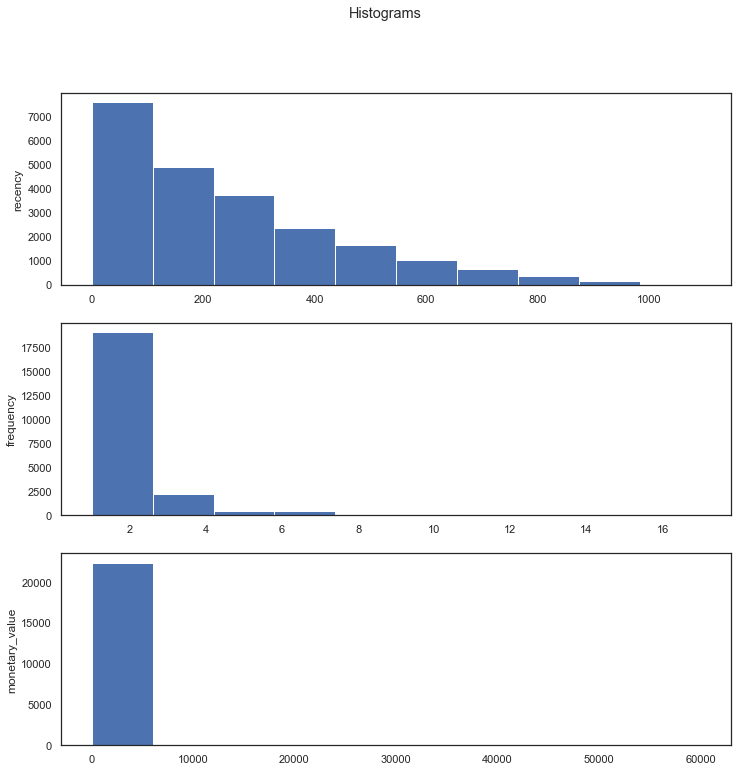

In [271]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Histograms')
rfm_df.recency.plot.hist(ax = ax1, figsize = (12,12));
rfm_df.frequency.sort_values().plot.hist(ax = ax2);
rfm_df.monetary_value.sort_values().plot.hist(ax = ax3);
ax1.set_ylabel('recency')
ax2.set_ylabel('frequency')
ax3.set_ylabel('monetary_value');

In [272]:
X = rfm_df.copy()
X.head()

,recency,frequency,monetary_value
userId,,,
2,678,1,2015.90
13,808,1,199.99
18,546,1,49.99
29,94,1,199.99
33,94,2,499.98


In [275]:
# Масштабируем признаки
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [276]:
# Поиск оптимального количества кластеров
inertia = []

for k in range(2,11):
    
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, random_state=2022)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

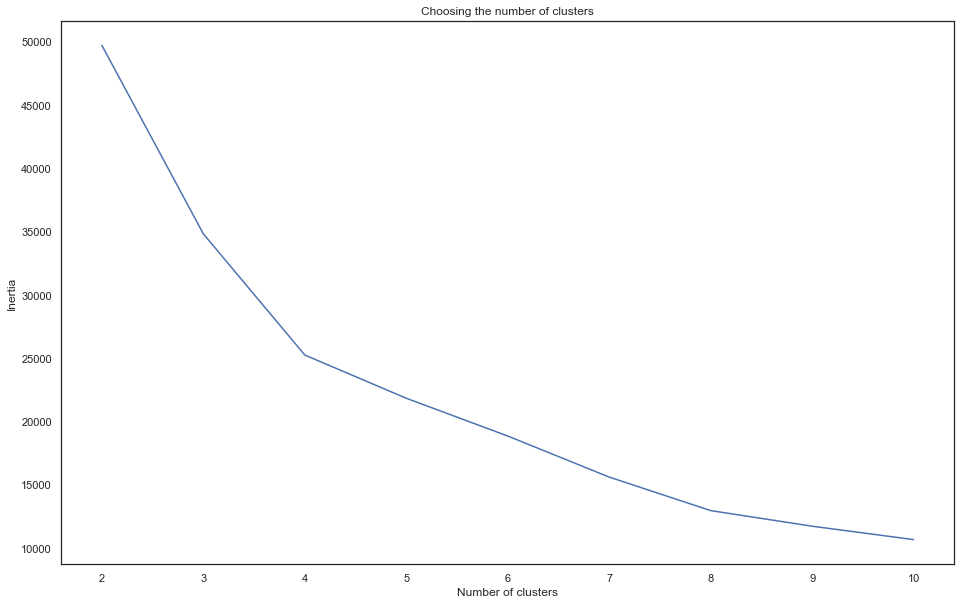

In [114]:
plt.plot(range(2, 11), inertia)
plt.title('Choosing the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [277]:
min(inertia), inertia[8]

(10669.691674932325, 10669.691674932325)

In [278]:
model = KMeans(n_clusters=8, init='k-means++', max_iter=50, random_state=2022)
model.fit(X_scaled)

KMeans(max_iter=50, random_state=2022)

In [279]:
cluster_labels = model.labels_

In [280]:
rfm_df['Cluster'] = cluster_labels

In [281]:
rfm_df['Profile'] = 'Low-Value'
rfm_df.loc[rfm_df['Cluster'] > 2, 'Profile'] = 'Mid-Value' 
rfm_df.loc[rfm_df['Cluster'] > 4, 'Profile'] = 'High-Value'

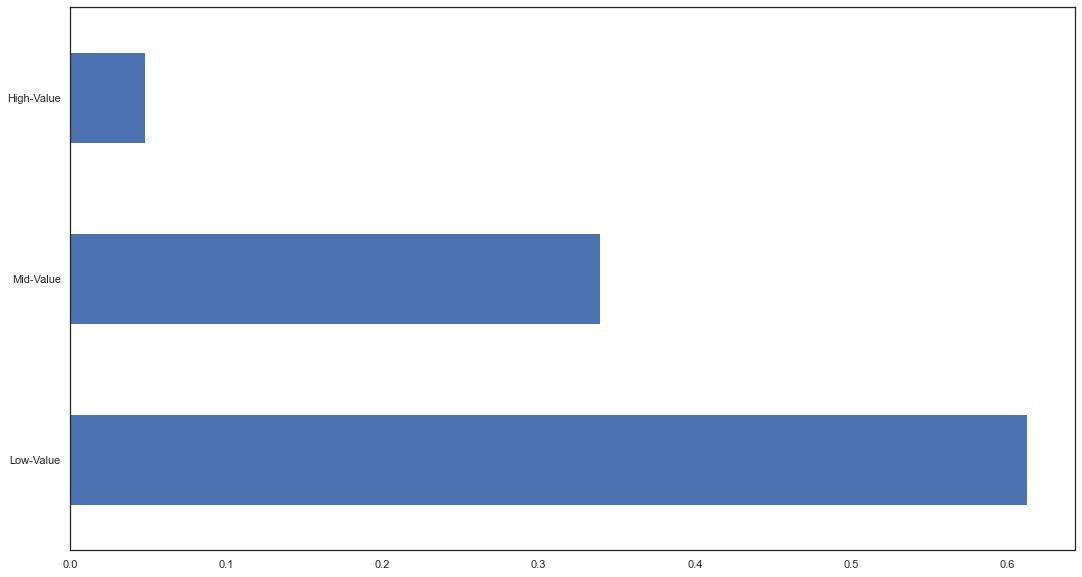

In [282]:
rfm_df.Profile.value_counts(normalize=True).plot.barh();

Исходя из проведенной кластеризации можно увидеть, что кластера очень несбалансированы: кластер "High Value" составляет всего 5% от общего числа, "Mid Value" примерно треть, и самый многочисленный кластер - "Low Value".

Что можно сделать по каждому из кластеров:

1. High Value:
    Нужно увеличивать Retention по этому кластеру, т.к клиенты из этого кластера самые высокоценные активы
2. Mid Value:
 Нужно увеличивать Retention и частоту покупок, чтобы эти клиенты перетекли в класс High Value
3. Low Value:
  Нужно увеличивать частоту покупок. Необходимо детельнее изучить почему клиенты уходят. Возможно имеются какие-то проблемы с продуктом или сервисом.